#1. 환경설정   
- 구글 드라이브 경로 설정 

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
DATA_PATH = '/content/gdrive/My Drive/DACON/sea_ice/data/train_v2.csv'
DIR_PATH = '/content/gdrive/My Drive/DACON/sea_ice/data/'
DIR_TRAIN_PATH = '/content/gdrive/My Drive/DACON/sea_ice/data/train_data_v2/'
MODEL_PATH='/content/gdrive/My Drive/DACON/sea_ice/model/'
SUBMISSION_PATH='/content/gdrive/My Drive/DACON/sea_ice/submission/'

 - Library Import

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

 - TPU 사용 설정

In [5]:
#TPU 설정
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.4.106.138:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.4.106.138:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.4.106.138:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


#2. Data Load  
 - 30년 데이터 사용



In [6]:
train_path = sorted(glob(DIR_TRAIN_PATH+'*.npy'))
train_path = train_path[-30*12:]

In [7]:
train = []
for p in tqdm(train_path):
    train.append(np.load(p))
train = np.array(train)

100%|██████████| 360/360 [02:04<00:00,  2.89it/s]


In [8]:
MAP_ROW_SIZE = train.shape[1]
MAP_COL_SIZE = train.shape[2]

#3. 데이터 전처리 
 - 북극점 미관측영역을 결빙도 250으로 채우기

In [9]:
train[:, :, :, 0] = train[:,:,:,0] + train[:,:,:,1] * 250

 - 월별 데이터로 분리

In [10]:
train_monthly = []

for i in range(12):
    train_monthly.append(train[i::12, :])

train_monthly = np.array(train_monthly)

In [11]:
train_monthly.shape

(12, 30, 448, 304, 5)

 -  30년간의 월별 평균 데이터 생성
 

In [12]:
train_monthly_mean =  np.zeros([12, MAP_ROW_SIZE, MAP_COL_SIZE])
for m in range(12):
    for i in range(MAP_ROW_SIZE):
        for j in range(MAP_COL_SIZE):
            train_monthly_mean[m][i][j] = train_monthly[m, :, i, j, 0].mean()



 - 평균 데이터 시각화

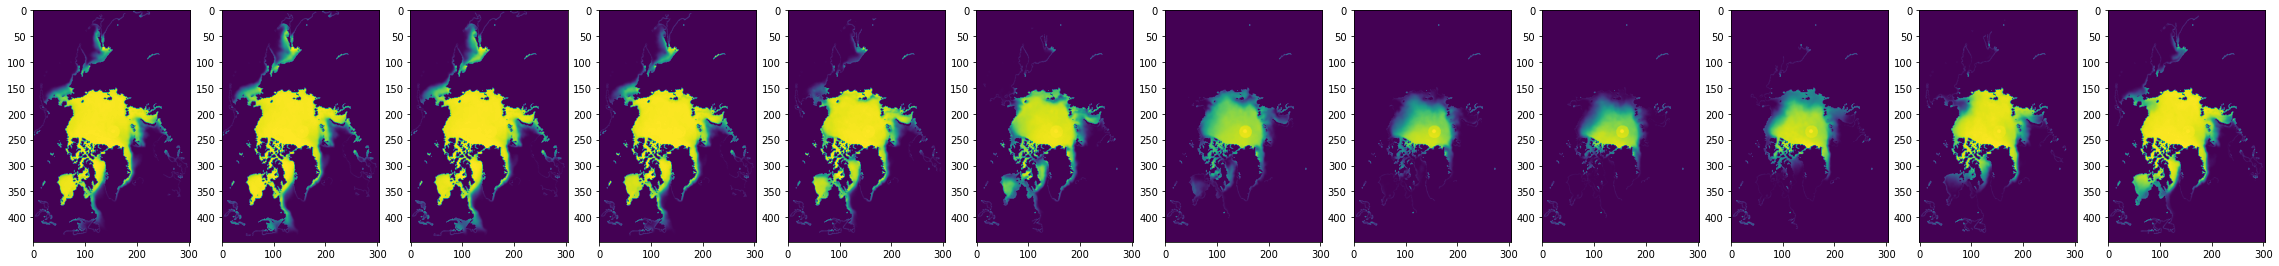

In [13]:
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(train_monthly_mean[month, :, :]) 
fig.show()

 - 결빙도 40% 기준으로 두 지역으로 나누기

In [14]:
#결빙도 평균 40%(100) 이상 지역 Masking Map 생성
high_map = []
temp_map = []
  

for m in range(12): 
    temp_map = train_monthly_mean[m].flatten()
    temp_map[np.where((temp_map > 0) & (temp_map < 100))] = 0
    temp_map[np.where(temp_map >= 100)] = 1
    high_map = np.append(high_map, temp_map)

high_map = high_map.reshape(12, MAP_ROW_SIZE, MAP_COL_SIZE)


 - 결빙도 평균 40% 이상지역 Masking Map 시각화

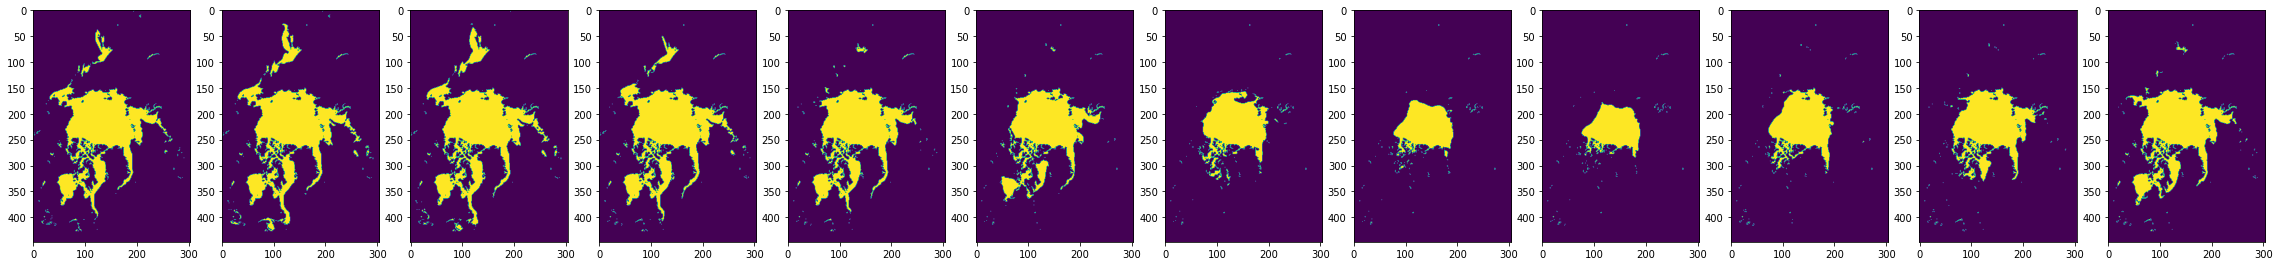

In [15]:
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(high_map[month, :, :]) 
fig.show()

In [16]:
#결빙도 40%(100) 이상 지역 외 지역 Masking Map
low_map =  np.zeros([12, MAP_ROW_SIZE, MAP_COL_SIZE])
 
low_map = high_map * -1 + 1

 - 결빙도 평균 40% 미만 지역 Masking Map 시각화

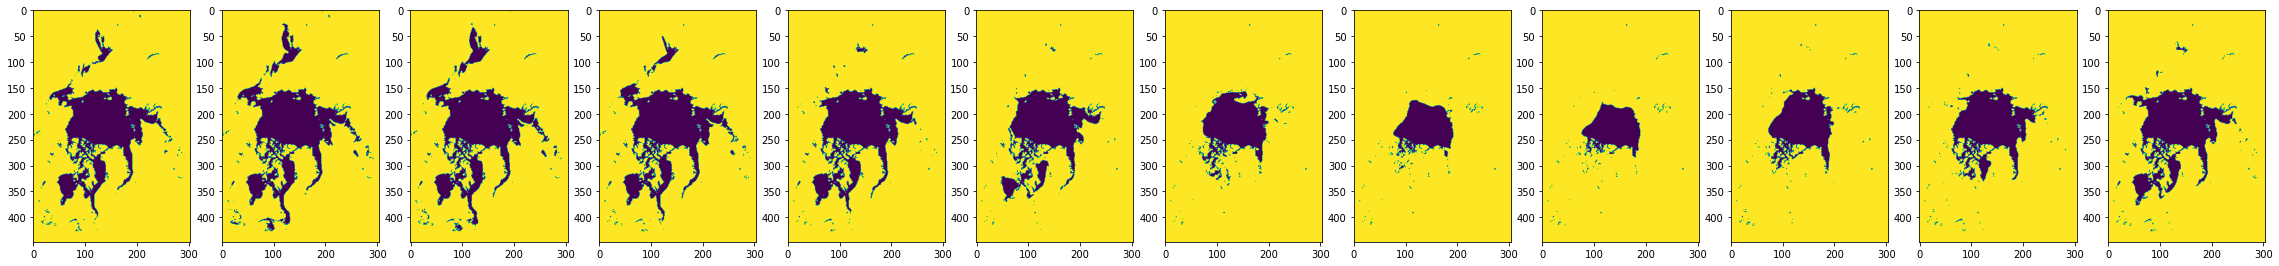

In [17]:
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(low_map[month, :, :]) 
fig.show()

 - 결빙도 평균 40% 이상지역 Masking Map 적용한 2019년 data 시각화

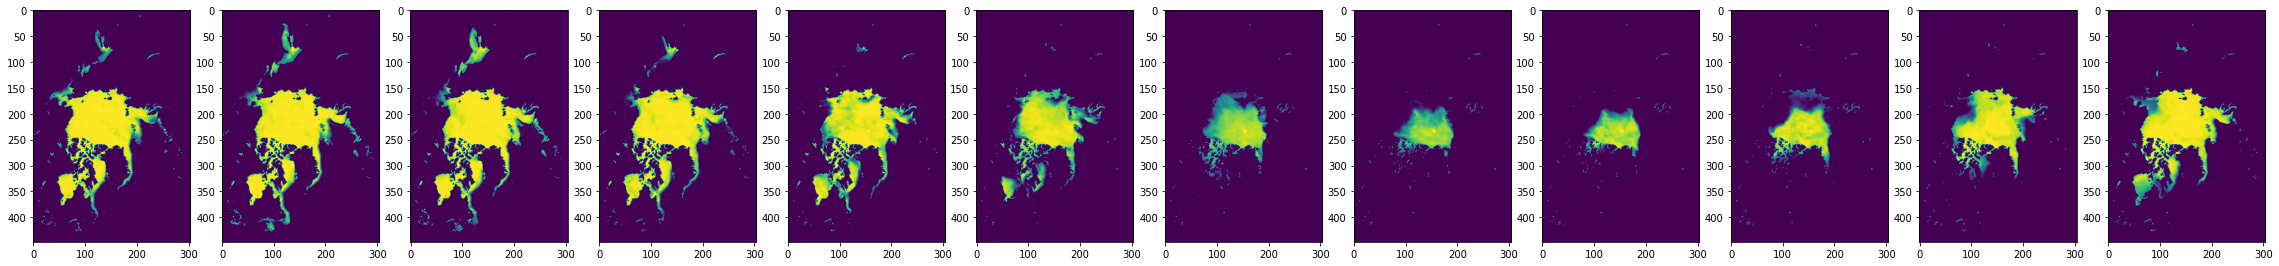

In [18]:
#high map을 적용한 2019년 data
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(train_monthly[month,-1, :, :, 0]  * high_map[month]) 
fig.show()

 - 결빙도 평균 40% 미만지역 Masking Map 적용한 2019년 data 시각화

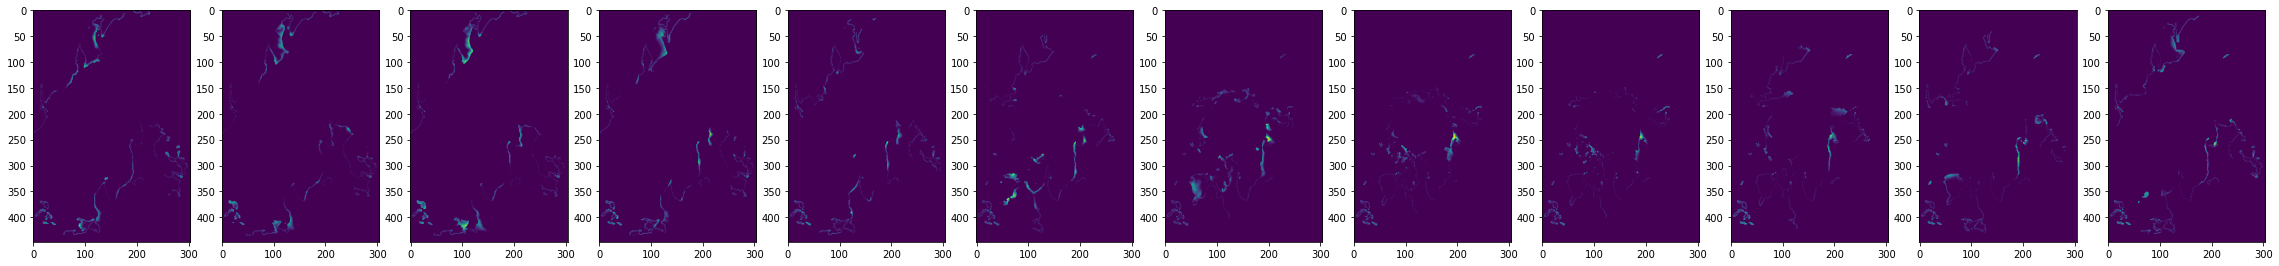

In [19]:
#low map을 적용한 2019년 data
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(train_monthly[month,-1, :, :, 0] * low_map[month]) 
fig.show()

In [20]:
train_high_area = []
train_low_area =[]
 


for index in range(train_monthly.shape[1]):
    for month in range(train_monthly.shape[0]):
        train_high_area.append( train_monthly[month, index, :, :, 0] * high_map[month] )
        train_low_area.append( train_monthly[month, index, :, :, 0] * low_map[month] )

train_high_area = np.array(train_high_area)
train_low_area = np.array(train_low_area)

In [21]:
train_high_area.shape, train_low_area.shape

((360, 448, 304), (360, 448, 304))

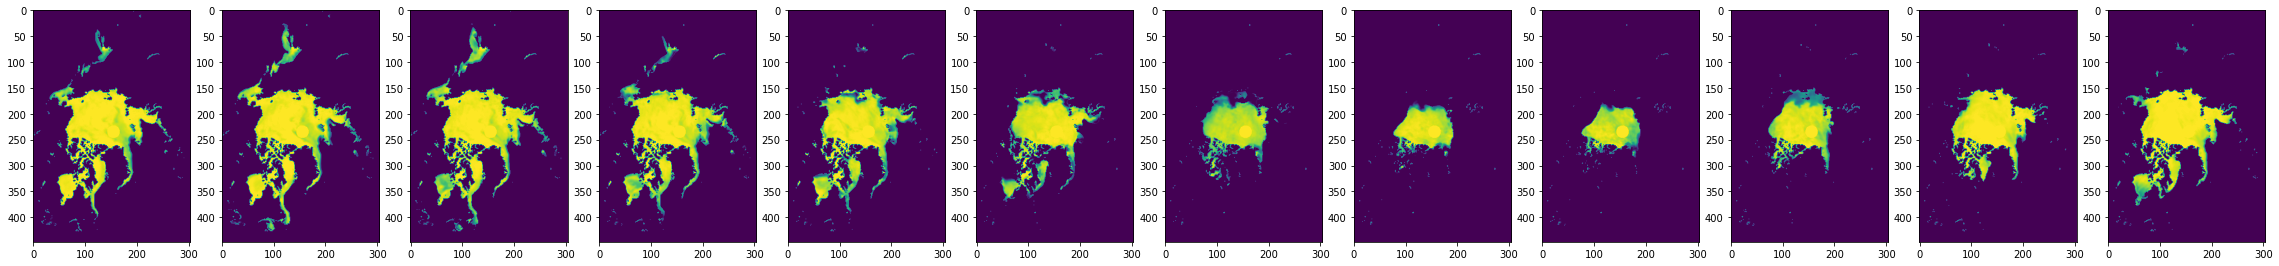

In [22]:
train_high_area = train_high_area.reshape(30, 12,MAP_ROW_SIZE, MAP_COL_SIZE)
 
index = 0
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(train_high_area[index,month, :, :]) 
fig.show()

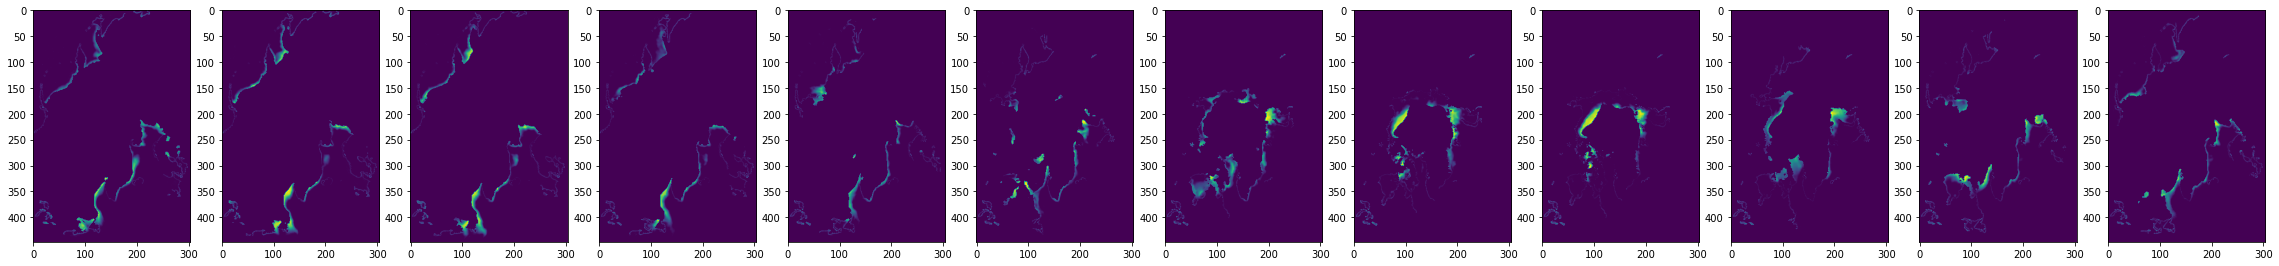

In [23]:
train_low_area = train_low_area.reshape(30, 12,MAP_ROW_SIZE, MAP_COL_SIZE)
 
index = 0
fig = plt.figure(figsize =  (40, 50))
for month in range(12):
    fig.add_subplot(1, 12, month +1)
    plt.imshow(train_low_area[index,month, :, :]) 
fig.show()
 

 - 결빙도 40%이상 지역의 결빙도 합 변화 그래프

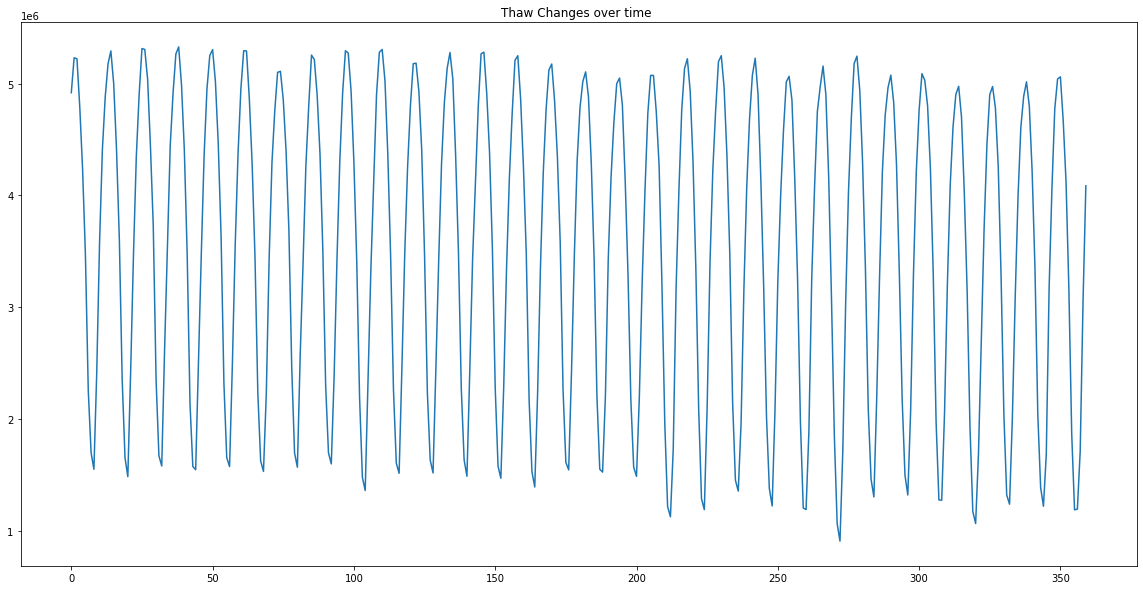

In [24]:
train_high_sum = []

train_high_sum = np.array(train_high_area.reshape(360, MAP_ROW_SIZE * MAP_COL_SIZE).sum(axis=1))
 
plt.figure(figsize = (20,10))
plt.title('Thaw Changes over time ')
plt.plot(train_high_sum)
plt.show()

 - 결빙도 40%미만 지역의 결빙도 합 변화 그래프

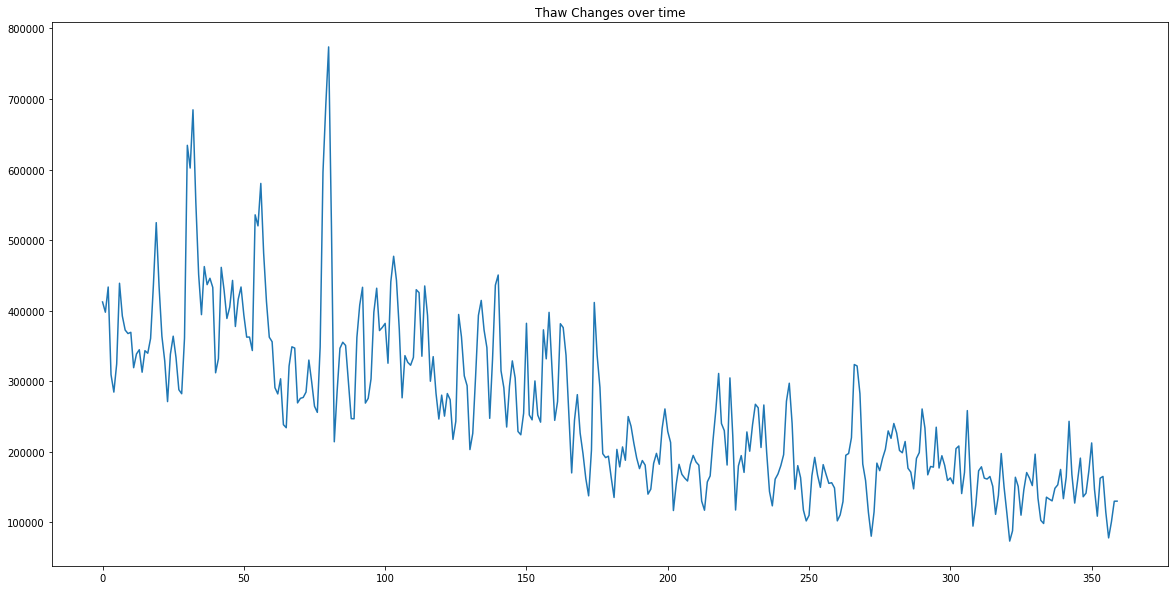

In [25]:
train_low_sum = []

train_low_sum = np.array(train_low_area.reshape(360, MAP_ROW_SIZE * MAP_COL_SIZE).sum(axis=1))
 
plt.figure(figsize = (20,10))
plt.title('Thaw Changes over time')
plt.plot(train_low_sum)
plt.show()

 - 월별 데이터로 분리

In [26]:
train_low_area = train_low_area.reshape(360, MAP_ROW_SIZE, MAP_COL_SIZE)
train_high_area = train_high_area.reshape(360, MAP_ROW_SIZE, MAP_COL_SIZE)

In [27]:
train_month = []
for i in range(12):
    train_month.append(train_low_area[i::12, :,:])

for i in range(12):
    train_month.append(train_high_area[i::12, :,:])

train_month = np.array(train_month)

In [28]:
train.shape, train_month.shape

((360, 448, 304, 5), (24, 30, 448, 304))

In [29]:
train_month = train_month.reshape(2, 12, 30, train_month.shape[2], train_month.shape[3] )

In [30]:
train_month.shape

(2, 12, 30, 448, 304)

 - stride 크기대로 이미지를 자를 수 있도록 패딩추가

In [31]:
stride = 32
temp = np.zeros([train_month.shape[0],
                 train_month.shape[1],
                 train_month.shape[2],
                 train_month.shape[3]+(stride-train_month.shape[3]%stride),
                 train_month.shape[4]+(stride-train_month.shape[4]%stride)],
                 np.uint8)
temp[:, :, :,:train_month.shape[3], :train_month.shape[4]] = train_month
train_month = temp
del temp

In [32]:
train_month.shape

(2, 12, 30, 480, 320)

#4. 학습 모델 설정

In [33]:
def makemodel():
    with strategy.scope():

        inputs = Input((None, x_train_.shape[2], x_train_.shape[3], 1))
 
        convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(inputs)
        convLSTM = BatchNormalization()(convLSTM)
 
        convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM) 
        convLSTM = BatchNormalization()(convLSTM)
 
        convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
        convLSTM = BatchNormalization()(convLSTM)
 
        outputs = Conv3D(filters=1, kernel_size=3, activation='relu', padding='same', data_format='channels_last')(convLSTM)
 
        model = tf.keras.Model(inputs, outputs)
        model.compile(loss='mae', optimizer=Adam())
 
    return model

In [34]:
LOW_AREA = 0
HIGH_AREA = 1
window_size = 5
feature_size = 128
BATCH_SIZE = 32

In [35]:
def train_map_func(x,y):
    x = tf.cast(x, tf.float32)/250
    y = tf.cast(y, tf.float32)
    return x,y

In [36]:
model_name_1 = "convlstm_area_40_low_model_20210409"
model_name_2 = "convlstm_area_40_high_model_20210409"

#5.1 low area 학습

In [37]:
x_train = []
y_train = []

for i in range(train_month.shape[2]-window_size):
    x_train.append(train_month[LOW_AREA,:, i: i+window_size,:,:])
    y_train.append(train_month[LOW_AREA,:, i+window_size: i+window_size+1,:,:])

x_train = np.array(x_train)
y_train = np.array(y_train)    

 - feature size 대로 데이터 자르기

In [38]:
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
            y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
            x_val_.append(x_)
            y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

In [39]:
x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape

((25200, 5, 128, 128),
 (25200, 1, 128, 128),
 (1008, 5, 128, 128),
 (1008, 1, 128, 128))

 - 데이터셋 만들기

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [41]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([32, 5, 128, 128]), TensorShape([32, 1, 128, 128]))

In [42]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([32, 5, 128, 128]), TensorShape([32, 1, 128, 128]))

 - 모델 생성

In [43]:
model = makemodel()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 128, 128, 1 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, None, 128, 128, 64 150016    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 128, 128, 64 256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 128, 128, 64 295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128, 128, 64 256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 128, 128, 64 295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 128, 128, 64 256   

In [44]:
#model.save_weights(MODEL_PATH + 'model_init_low_20210409.h5')
model.load_weights(MODEL_PATH + 'model_init_low_20210409.h5')

 - 학습

In [ ]:
#tf.keras.backend.clear_session()
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = MODEL_PATH + model_name_1 + '.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks_list)

Epoch 1/20
788/788 [==============================] - 415s 494ms/step - loss: 2.1034 - val_loss: 0.7338
Epoch 2/20
788/788 [==============================] - 342s 434ms/step - loss: 2.0481 - val_loss: 0.8147
Epoch 3/20
788/788 [==============================] - 342s 434ms/step - loss: 2.0007 - val_loss: 0.7188
Epoch 4/20
788/788 [==============================] - 342s 434ms/step - loss: 1.9786 - val_loss: 0.7207
Epoch 5/20
788/788 [==============================] - 342s 434ms/step - loss: 1.9876 - val_loss: 0.7298
Epoch 6/20
788/788 [==============================] - 342s 434ms/step - loss: 1.9726 - val_loss: 0.8652
Epoch 7/20
788/788 [==============================] - 342s 434ms/step - loss: 1.9629 - val_loss: 1.0195
Epoch 8/20
788/788 [==============================] - 342s 434ms/step - loss: 1.9685 - val_loss: 0.7084
Epoch 9/20
788/788 [==============================] - 342s 434ms/step - loss: 1.9526 - val_loss: 0.8763
Epoch 10/20
788/788 [==============================] - 342s 434m

#5.2 high area 학습

In [ ]:
x_train = []
y_train = []

for i in range(train_month.shape[2]-window_size):
    x_train.append(train_month[HIGH_AREA,:, i: i+window_size,:,:])
    y_train.append(train_month[HIGH_AREA,:, i+window_size: i+window_size+1,:,:])

x_train = np.array(x_train)
y_train = np.array(y_train)    

 - feature size 대로 데이터 자르기

In [ ]:
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
            y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, ]
            x_val_.append(x_)
            y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

In [ ]:
x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape

((25200, 5, 128, 128),
 (25200, 1, 128, 128),
 (1008, 5, 128, 128),
 (1008, 1, 128, 128))

 - 데이터셋 만들기

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([32, 5, 128, 128]), TensorShape([32, 1, 128, 128]))

In [ ]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([32, 5, 128, 128]), TensorShape([32, 1, 128, 128]))

 - 모델 생성

In [ ]:
model = makemodel()

In [ ]:
#model.save_weights(MODEL_PATH + 'model_init_high_20210409.h5')
model.load_weights(MODEL_PATH + 'model_init_high_20210409.h5')

 - 학습

In [ ]:
tf.keras.backend.clear_session()
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = MODEL_PATH + model_name_2 + '.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks_list)

Epoch 1/20
788/788 [==============================] - 413s 493ms/step - loss: 16.5762 - val_loss: 7.1046
Epoch 2/20
788/788 [==============================] - 341s 433ms/step - loss: 5.4864 - val_loss: 5.0559
Epoch 3/20
788/788 [==============================] - 341s 433ms/step - loss: 4.9792 - val_loss: 5.1328
Epoch 4/20
788/788 [==============================] - 341s 433ms/step - loss: 4.3354 - val_loss: 4.8804
Epoch 5/20
788/788 [==============================] - 342s 434ms/step - loss: 3.8648 - val_loss: 4.2884
Epoch 6/20
788/788 [==============================] - 341s 433ms/step - loss: 3.4859 - val_loss: 4.1200
Epoch 7/20
788/788 [==============================] - 342s 434ms/step - loss: 3.4730 - val_loss: 4.2464
Epoch 8/20
788/788 [==============================] - 342s 434ms/step - loss: 3.4529 - val_loss: 3.8339
Epoch 9/20
788/788 [==============================] - 342s 434ms/step - loss: 3.2247 - val_loss: 3.8900
Epoch 10/20
788/788 [==============================] - 342s 434

#6. 추론   

 - TTS

In [45]:
voting_mask = np.zeros((train_month.shape[3], train_month.shape[4]))
ones = np.ones((feature_size, feature_size))

for i in range((train_month.shape[3]-feature_size)//stride+1):
    for j in range((train_month.shape[4]-feature_size)//stride+1):
        voting_mask[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += ones

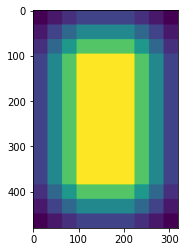

In [46]:
plt.imshow(voting_mask)

 - low 지역 추론
 

In [47]:
model = load_model(MODEL_PATH + model_name_1 + '.h5')

x_test = train_month[LOW_AREA, :, -1*window_size:,:]
x_test = np.swapaxes(x_test , 0, 1)

x_test_ = []
for m in range(12):
    feature = []
    for i in range((train_month.shape[3]-feature_size)//stride+1):
        for j in range((train_month.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)


preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)


results_low = []
for m in range(12):
    pred = np.zeros((train_month.shape[3], train_month.shape[4]))
    k = 0
    for i in range((train_month.shape[3]-feature_size)//stride+1):
        for j in range((train_month.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results_low.append(pred[:MAP_ROW_SIZE, :MAP_COL_SIZE])
results_low = np.array(results_low)


100%|██████████| 12/12 [01:32<00:00,  7.72s/it]


 - high 지역 추론

In [48]:
model = load_model(MODEL_PATH + model_name_2 + '.h5')

x_test = train_month[HIGH_AREA, :, -1*window_size:,:,:]
x_test = np.swapaxes(x_test , 0, 1)

x_test_ = []
for m in range(12):
    feature = []
    for i in range((train_month.shape[3]-feature_size)//stride+1):
        for j in range((train_month.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)


preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)


results_high = []
for m in range(12):
    pred = np.zeros((train_month.shape[3], train_month.shape[4]))
    k = 0
    for i in range((train_month.shape[3]-feature_size)//stride+1):
        for j in range((train_month.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results_high.append(pred[:MAP_ROW_SIZE, :MAP_COL_SIZE])
results_high = np.array(results_high)

100%|██████████| 12/12 [01:35<00:00,  7.94s/it]


 - LOW + HIGH 데이터 결합

In [80]:
results2020 = []
for m in range(12):
    results2020.append(results_low[m] * low_map[m] + results_high[m] * high_map[m])
 
results2020 = np.array(results2020)

In [81]:
results2020.shape

(12, 448, 304)

#7. 후처리

 - 2019년 12월 Data Load

In [82]:
train = pd.read_csv(DIR_PATH + 'train_v2.csv')

#north_pole_mask from 2019 December
data_dec = np.load(DIR_TRAIN_PATH+train['file_nm'][493]) 

 - 후처리 1: 북극점 미관측영역 마스크 만들기  및 적용

In [83]:
north_pole_mask = data_dec[:, :, 1] * -1 + 1

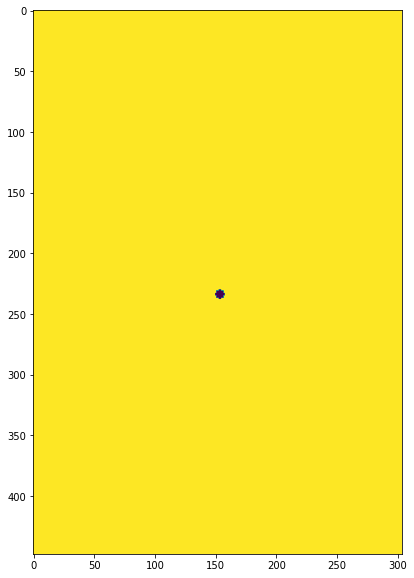

In [84]:
plt.figure(figsize = (20,10))
tmpimg = north_pole_mask
plt.imshow(tmpimg)

In [86]:
for m in range(12):
    results2020[m, : , : ] = results2020[m, : , : ] * north_pole_mask

 - 후처리 2: 육지 + 해안선 마스크 만들기 및 적용



In [87]:
landmask = ((data_dec[:, :, 2] + data_dec[:, :, 3])-1)/255

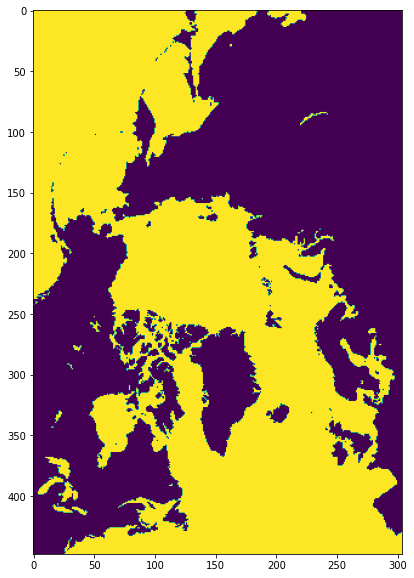

In [88]:
plt.figure(figsize = (20,10))
tmpimg = landmask
plt.imshow(tmpimg)

In [89]:
for m in range(12):
    results2020[m, : , : ] = results2020[m, : , : ] * landmask

#8. 추론 결과 확인

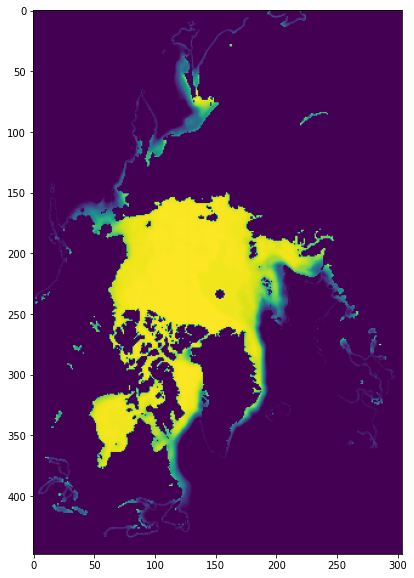

1 



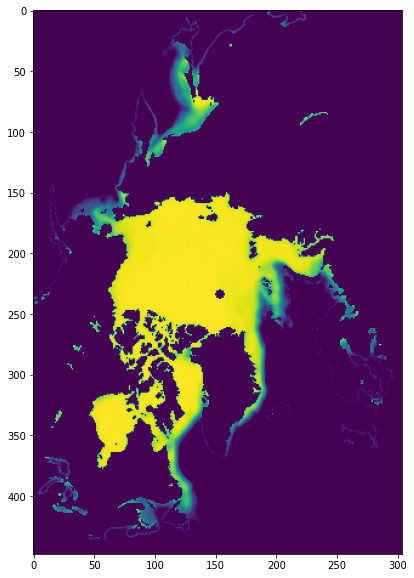

2 



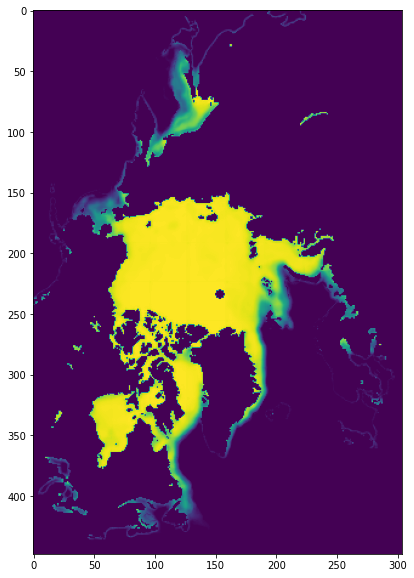

3 



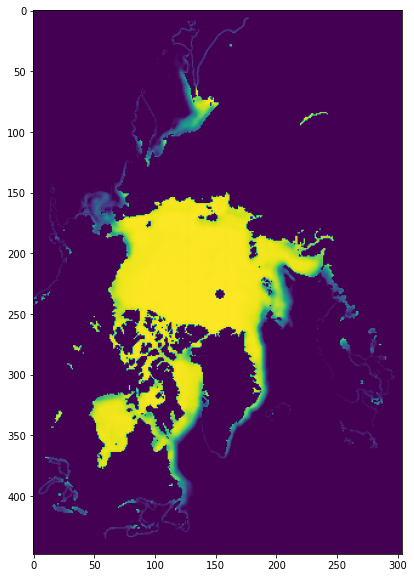

4 



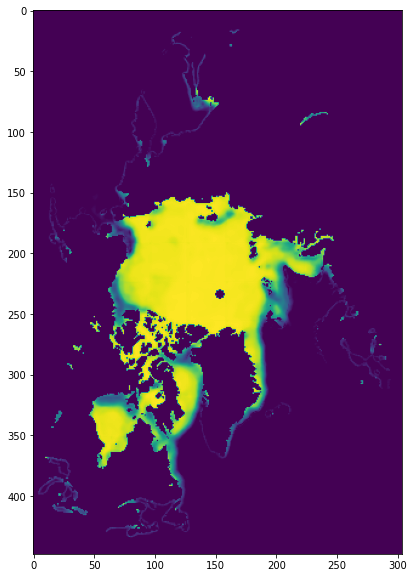

5 



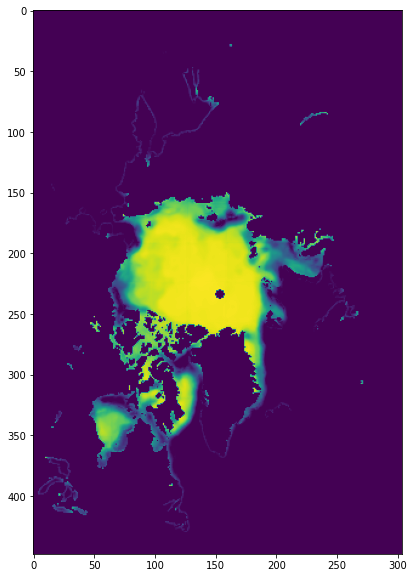

6 



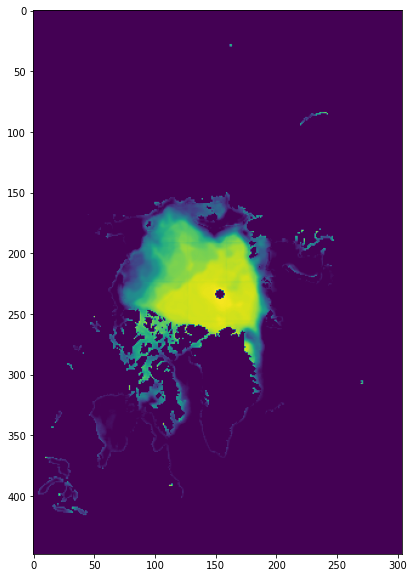

7 



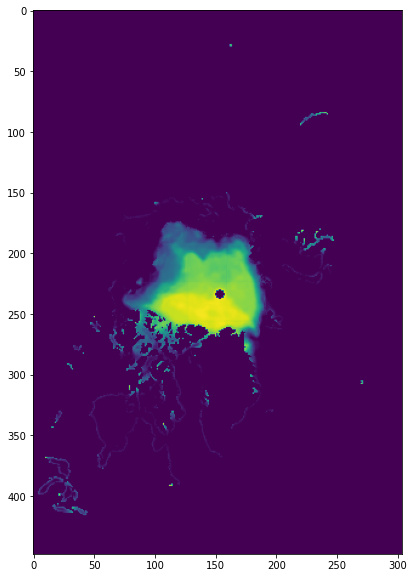

8 



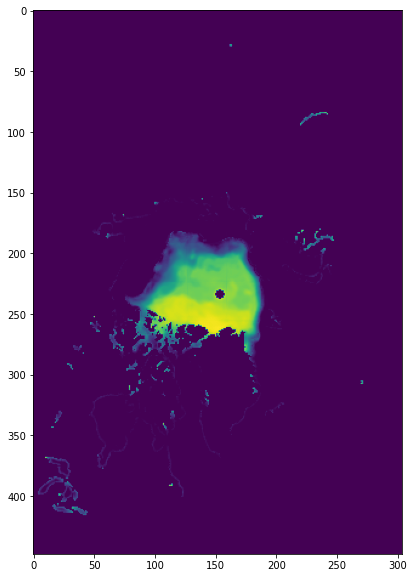

9 



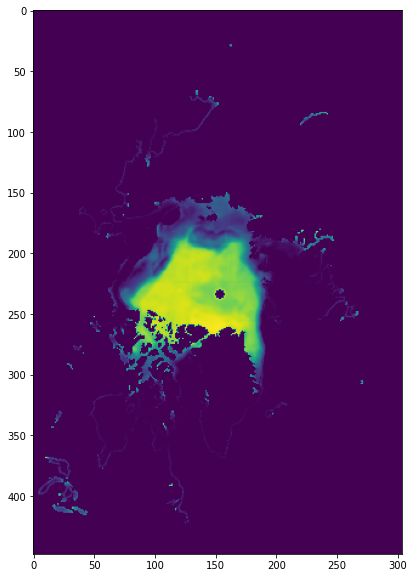

10 



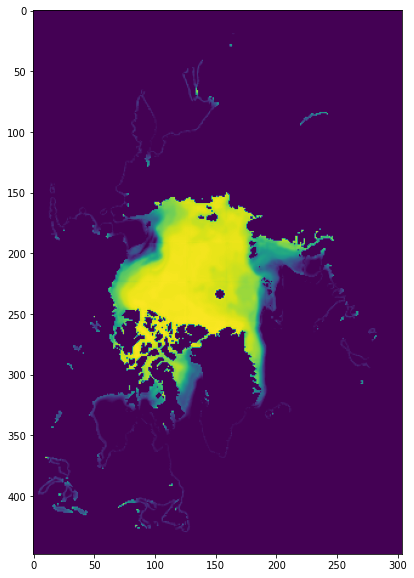

11 



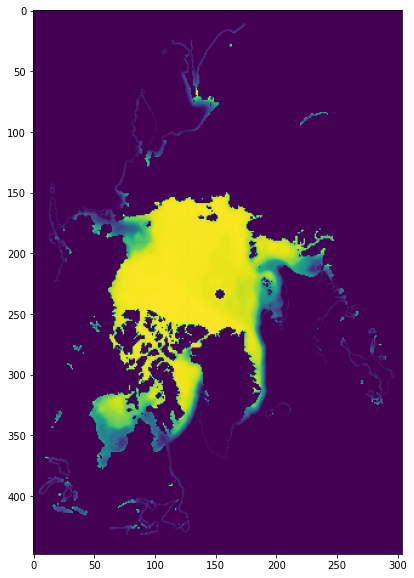

12 



In [90]:
for m in range(12):
    plt.figure(figsize = (20,10))
    plt.imshow(results[m])
    plt.show()
    print(m+1, '\n')

In [91]:
results2020.sum(), results2020.shape

(40318018.66797465, (12, 448, 304))

#9. 제출 파일 생성

In [92]:
submission = pd.read_csv(DIR_PATH+'sample_submission.csv')
#submission

In [93]:
results_2019 = []
for m in range(12): 
    data_2019 = np.load(DIR_TRAIN_PATH+train['file_nm'][482 + m])   
    results_2019.append(data_2019[:, :, 0])
results_2019 = np.array(results_2019) 

In [94]:
results_2019.shape, results2020.shape

((12, 448, 304), (12, 448, 304))

In [95]:
results_final = np.append(results_2019 ,  results2020)

In [96]:
results_final = results_final.reshape(24,448, 304 )
results_final.shape

(24, 448, 304)

In [98]:
submission_final = submission.loc[:, ['month']].copy()
submission_final = pd.concat([submission_final, (pd.DataFrame(results_final.reshape([24,-1])))], axis=1)
submission_final.columns = submission.columns

In [102]:
file_path =  SUBMISSION_PATH + "ConvLSTM_area40_20210409" + '.csv'
submission_final.to_csv(file_path, index=False, header=True)

In [103]:
file_path

'/content/gdrive/My Drive/DACON/sea_ice/submission/ConvLSTM_area40_20210409.csv'

In [104]:
submission_final.sum()

month     2019-012019-022019-032019-042019-052019-062019...
0                                                         0
1                                                         0
2                                                         0
3                                                         0
                                ...                        
136187                                                    0
136188                                                    0
136189                                                    0
136190                                                    0
136191                                                    0
Length: 136193, dtype: object